=== Image Mosaicing Demo ===
[[ 2.22591775e-01  4.56878247e-02  5.29720482e+02]
 [-2.29155603e-01  7.46439703e-01  8.58509730e+01]
 [-6.24009235e-04 -7.10597037e-06  1.00000000e+00]]


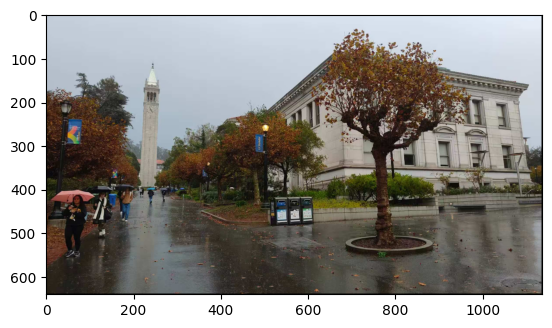

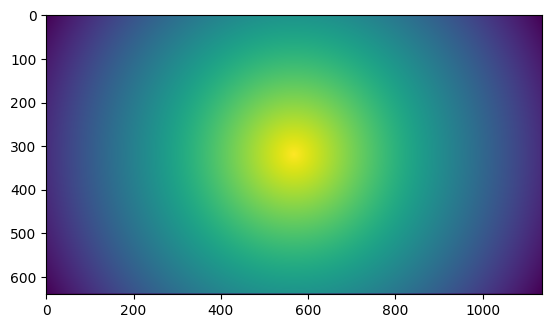

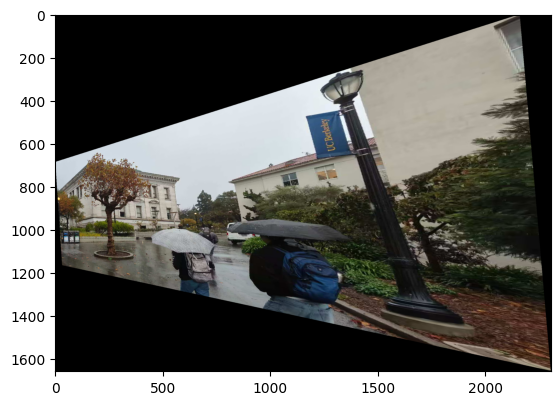

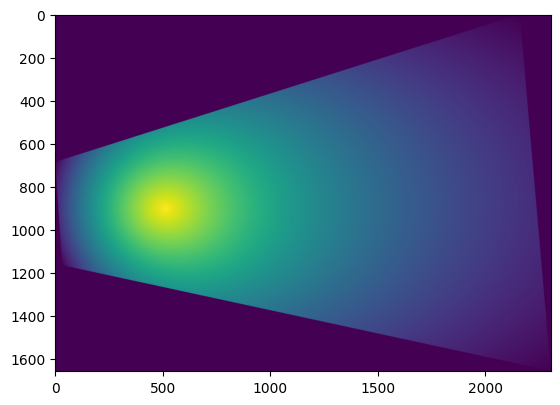

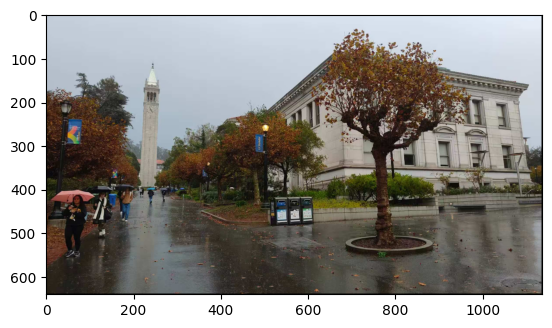

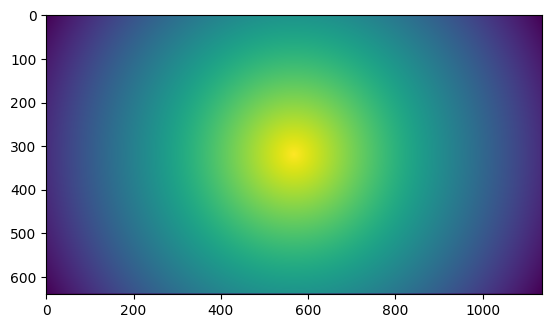

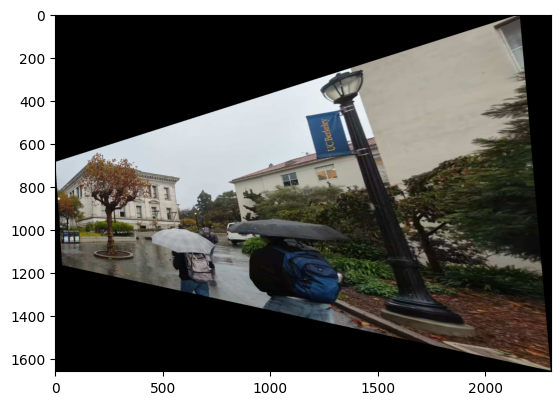

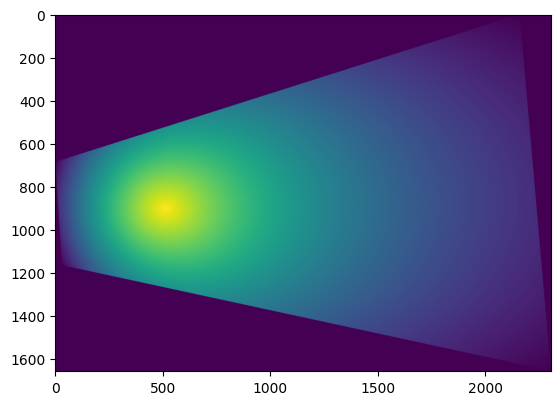

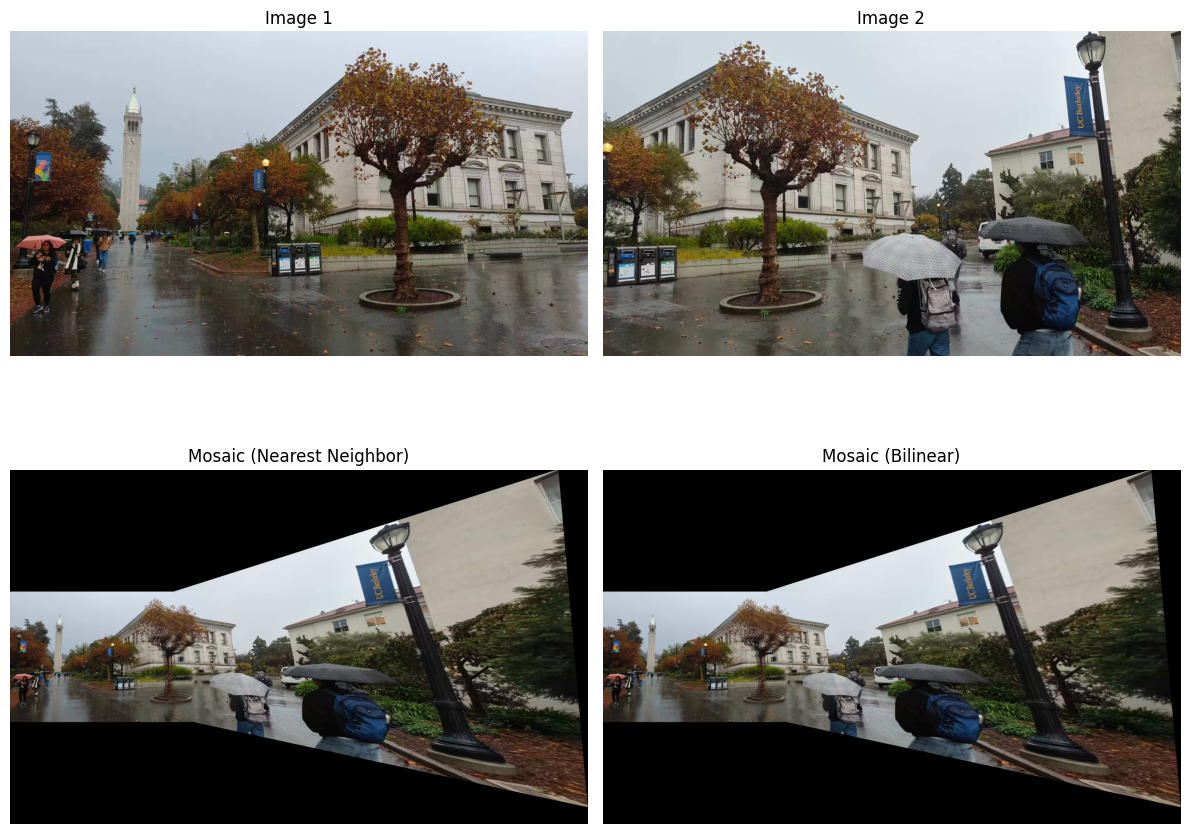


=== Summary ===
1. Homography computation implemented
2. Two interpolation methods implemented: Nearest Neighbor and Bilinear
3. Image rectification demonstrated
4. Image mosaicing demonstrated
5. Alpha blending used for seamless mosaicing


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy import ndimage
from scipy.spatial.distance import cdist
import cv2

group = "3"
cnt = 0
os.makedirs('./results', exist_ok=True)

def read(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))
    return img

def computeH(im1_pts, im2_pts):
    n = im1_pts.shape[0]
    
    A = np.zeros((2*n, 8))
    b = np.zeros((2*n, 1))
    
    for i in range(n):
        x, y = im1_pts[i]
        u, v = im2_pts[i]
        
        A[2*i, 0:2] = [x, y]        # h11*x + h12*y
        A[2*i, 2] = 1               # h13
        A[2*i, 6:8] = [-u*x, -u*y]  # -h31*u*x - h32*u*y
        b[2*i] = u                  # = u
        
        A[2*i+1, 3:5] = [x, y]          # h21*x + h22*y
        A[2*i+1, 5] = 1                 # h23
        A[2*i+1, 6:8] = [-v*x, -v*y]    # -h31*v*x - h32*v*y
        b[2*i+1] = v                    # = v
    
    h = np.linalg.lstsq(A, b, rcond=None)[0]
    
    H = np.array([
        [h[0, 0], h[1, 0], h[2, 0]],
        [h[3, 0], h[4, 0], h[5, 0]],
        [h[6, 0], h[7, 0], 1]
    ])
    
    return H

def warpImage(im, H, method='bilinear'):
    if len(im.shape) == 3:
        h, w, c = im.shape
    else:
        h, w = im.shape
        c = 1
        im = im[:, :, np.newaxis]
    
    corners = np.array([[0, 0, 1], [w-1, 0, 1], [0, h-1, 1], [w-1, h-1, 1]]).T
    warped_corners = H @ corners
    warped_corners = warped_corners / warped_corners[2, :]
    
    min_x = np.floor(np.min(warped_corners[0, :])).astype(int)
    max_x = np.ceil(np.max(warped_corners[0, :])).astype(int)
    min_y = np.floor(np.min(warped_corners[1, :])).astype(int)
    max_y = np.ceil(np.max(warped_corners[1, :])).astype(int)
    
    out_w = max_x - min_x + 1
    out_h = max_y - min_y + 1
    
    warped_im = np.zeros((out_h, out_w, c), dtype=im.dtype)
    
    H_inv = np.linalg.inv(H)

    for y_out in range(out_h):
        for x_out in range(out_w):
            x_warp = x_out + min_x
            y_warp = y_out + min_y
            
            warp_point = np.array([x_warp, y_warp, 1])
            
            src_point = H_inv @ warp_point
            src_point = src_point / src_point[2]
            
            x_src, y_src = src_point[0], src_point[1]
            
            if 0 <= x_src < w-1 and 0 <= y_src < h-1:
                if method == 'nearest':
                    x_near = int(round(x_src))
                    y_near = int(round(y_src))
                    warped_im[y_out, x_out, :] = im[y_near, x_near, :]
                else:  # bilinear
                    x_floor, y_floor = int(np.floor(x_src)), int(np.floor(y_src))
                    x_ceil, y_ceil = x_floor + 1, y_floor + 1
                    
                    dx = x_src - x_floor
                    dy = y_src - y_floor
                    
                    p1 = im[y_floor, x_floor, :]
                    p2 = im[y_floor, x_ceil, :]
                    p3 = im[y_ceil, x_floor, :]
                    p4 = im[y_ceil, x_ceil, :]
                    
                    warped_im[y_out, x_out, :] = (
                        (1-dx)*(1-dy)*p1 + 
                        dx*(1-dy)*p2 + 
                        (1-dx)*dy*p3 + 
                        dx*dy*p4
                    )
    
    if c == 1:
        warped_im = warped_im[:, :, 0]

    plt.imshow(warped_im)
    plt.show()
        
    return warped_im, (min_x, min_y, max_x, max_y)

def warpImageNearestNeighbor(im, H):
    return warpImage(im, H, method='nearest')

def warpImageBilinear(im, H):
    return warpImage(im, H, method='bilinear')

def create_mosaic(images, homographies, method='bilinear'):
    global cnt
    global group
    if len(images) != len(homographies) + 1:
        raise ValueError("Number of homographies should be one less than number of images")
    
    base_im = images[0]
    mosaic = base_im.copy().astype(np.float32)
    
    alphas = []
    for i, im in enumerate(images):
        h, w = im.shape[:2]
        alpha = np.ones((h, w))
        
        center_y, center_x = h//2, w//2
        y_coords, x_coords = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
        max_dist = np.sqrt(center_x**2 + center_y**2)
        alpha = 1 - dist_from_center / max_dist
        alpha = np.clip(alpha, 0, 1)
        
        alphas.append(alpha)

    warped_images = []
    warped_alphas = []
    bboxs = []
    min_x, min_y = 0, 0
    max_x, max_y = base_im.shape[:2]

    for i in range(len(images)):
        if i == 0:
            H = np.eye(3)
        else:
            H = homographies[i-1]
        
        if method == 'nearest':
            warped_im, bbox = warpImageNearestNeighbor(images[i], H)
            warped_alpha, _ = warpImageNearestNeighbor(alphas[i], H)
            cnt += 1
            plt.imsave('./results/'+ group + '_' + str(cnt) + '_warped_nearest.jpg', warped_im.astype(np.uint8))
            plt.imsave('./results/'+ group + '_' + str(cnt) + '_alpha_nearest.jpg', warped_alpha)

        else:
            warped_im, bbox = warpImageBilinear(images[i], H)
            warped_alpha, _ = warpImageBilinear(alphas[i], H)
            cnt += 1
            plt.imsave('./results/'+ group + '_' + str(cnt) + '_warped_bilinear.jpg', warped_im.astype(np.uint8))
            plt.imsave('./results/'+ group + '_' + str(cnt) + '_alpha_bilinear.jpg', warped_alpha)
        warped_images.append(warped_im)
        warped_alphas.append(warped_alpha)
        
        x1, y1, x2, y2 = bbox
        bboxs.append(bbox)

        min_x = min(min_x, x1)
        min_y = min(min_y, y1)
        max_x = max(max_x, x2)
        max_y = max(max_y, y2)

    h, w = max_y - min_y + 1, max_x - min_x + 1

    mosaic = np.zeros((h, w, 3), dtype=np.float32)
    total_alpha = np.zeros((h, w), dtype=np.float32)

    for i in range(len(images)):
        x1, y1, x2, y2 = bboxs[i]
        mosaic[-min_y+y1:-min_y+y2+1, -min_x+x1:-min_x+x2+1] += warped_images[i][:] * warped_alphas[i][:, :, np.newaxis]
        total_alpha[-min_y+y1:-min_y+y2+1, -min_x+x1:-min_x+x2+1] += warped_alphas[i][:]

    mosaic /= total_alpha[:, :, np.newaxis] + 1e-8  # 防止除以零
        
    return np.clip(mosaic, 0, 255).astype(np.uint8)

def show():
    im1_pts, im2_pts = np.load('./points/1.npz').values()
    im1 = read('./img/1_1.jpg')
    im2 = read('./img/1_2.jpg')
    for pt in im1_pts:
        cv2.circle(im1, (int(pt[0]), int(pt[1])), 5, (255,0,0), -1)
    for pt in im2_pts:
        cv2.circle(im2, (int(pt[0]), int(pt[1])), 5, (255,0,0), -1)
    cv2.imshow('im1', im1)
    cv2.imshow('im2', im2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# matplotlib.use('TkAgg')
def demo_mosaic():
    print("=== Image Mosaicing Demo ===")
    
    im1 = read('./img/'+group+'_1.jpg')
    im2 = read('./img/'+group+'_2.jpg')
    # im3 = read('./img/'+group+'_3.jpg')

    data = np.load('./points/'+group+'_12.npz')
    im1_pts = data['im1_pts']
    im2_pts = data['im2_pts']
    H1 = computeH(im2_pts, im1_pts)
    print(H1)

    # data = np.load('./points/'+group+'_13.npz')
    # im1_pts = data['im1_pts']
    # im2_pts = data['im2_pts']
    # H2 = computeH(im2_pts, im1_pts)
    # print(H2)

    mosaic_nn = create_mosaic([im1, im2], [H1], method='nearest')
    global cnt
    cnt = 0
    mosaic_bil = create_mosaic([im1, im2], [H1], method='bilinear')
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0, 0].imshow(im1)
    axes[0, 0].set_title('Image 1')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(im2)
    axes[0, 1].set_title('Image 2')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(mosaic_nn)
    axes[1, 0].set_title('Mosaic (Nearest Neighbor)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(mosaic_bil)
    axes[1, 1].set_title('Mosaic (Bilinear)')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    plt.imsave('./results/'+ group + '_1_origin.jpg', im1)
    plt.imsave('./results/'+ group + '_2_origin.jpg', im2)
    # plt.imsave('./results/'+ group + '_3_origin.jpg', im3)
    plt.imsave('./results/'+ group + '_mosaic_nearest.jpg', mosaic_nn)
    plt.imsave('./results/'+ group + '_mosaic_bilinear.jpg', mosaic_bil)
    
    return mosaic_nn, mosaic_bil

if __name__ == "__main__":
    mosaic_nn, mosaic_bil = demo_mosaic()
    
    print("\n=== Summary ===")
    print("1. Homography computation implemented")
    print("2. Two interpolation methods implemented: Nearest Neighbor and Bilinear")
    print("3. Image rectification demonstrated")
    print("4. Image mosaicing demonstrated")
    print("5. Alpha blending used for seamless mosaicing")